### GTSRB

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, Compose, Grayscale

training_data = datasets.GTSRB(
    root="data",
    split="train",
    transform=Compose(
        [Resize((40, 40)),
         Grayscale(num_output_channels=1),
         ToTensor(),
        ]
    ),
    download=True,
)

test_data = datasets.GTSRB(
    root="data",
    split="test",
    transform=Compose(
        [Resize((40, 40)),
         Grayscale(num_output_channels=1),
         ToTensor(),
        ]
    ),
    download=True,
)

1


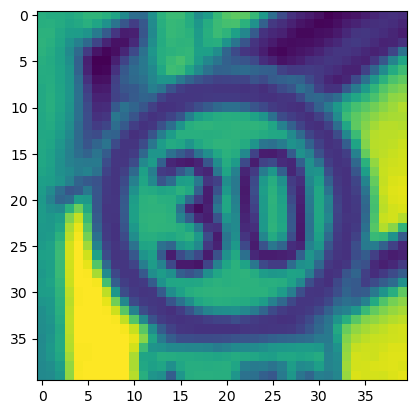

In [36]:
img, label = training_data[1220]
plt.imshow(img.squeeze())
print(label)

In [32]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

print((train_dataloader.dataset[1][0]).size())


torch.Size([1, 40, 40])


In [21]:
from torch import nn
from torchvision import transforms

# choose device
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"using {device} device")

# subclass
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.structure = nn.Sequential(
            nn.Linear(40*40, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 43),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.structure(x)
        return logits

# instance of class
model = NeuralNetwork().to(device)
print(model)

# use model
X = torch.rand(1, 40, 40, device=device)
logits = model(X)
# output is 1x10 raw predicted val for each class, passed through softmax for largest prediction
pred_probab = nn.Softmax(dim=1)(logits)
# y_pred = torch.argmax(pred_probab) # argmax doesn't work on mps
y_pred = pred_probab.max(dim=1).indices
print(f"Predicted class: {y_pred}")


using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (structure): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=43, bias=True)
  )
)
Predicted class: tensor([31], device='mps:0')


In [34]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # print(X.size())
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.max(dim=1).indices ==
                        y).type(torch.float).sum().item() # (!) debug: removed .sum() before item

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# parameters
learning_rate = 1e-3
# batch_size = 64
epochs = 10

# implementation
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 3.724604  [   64/26640]
loss: 3.688076  [ 6464/26640]
loss: 3.683521  [12864/26640]
loss: 3.713882  [19264/26640]
loss: 3.659404  [25664/26640]
Test Error: 
 Accuracy: 7.5%, Avg loss: 3.658449 

Epoch 2
-------------------------------
loss: 3.618415  [   64/26640]
loss: 3.600454  [ 6464/26640]
loss: 3.602107  [12864/26640]
loss: 3.641207  [19264/26640]
loss: 3.591269  [25664/26640]
Test Error: 
 Accuracy: 7.9%, Avg loss: 3.589052 

Epoch 3
-------------------------------
loss: 3.592000  [   64/26640]
loss: 3.557486  [ 6464/26640]
loss: 3.647188  [12864/26640]
loss: 3.560030  [19264/26640]
loss: 3.590512  [25664/26640]
Test Error: 
 Accuracy: 8.1%, Avg loss: 3.539227 

Epoch 4
-------------------------------
loss: 3.455895  [   64/26640]
loss: 3.474161  [ 6464/26640]
loss: 3.510031  [12864/26640]
loss: 3.520896  [19264/26640]
loss: 3.651306  [25664/26640]
Test Error: 
 Accuracy: 8.0%, Avg loss: 3.515723 

Epoch 5
----------------------------